In [1]:
import warnings;
warnings.simplefilter('ignore')

In [2]:
#!pip install prophet

In [48]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import pickle
import numpy as np
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

%matplotlib inline


# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})




In [4]:
data = pd.read_csv('crime-per-county.csv')

In [5]:
data.head()


STATISTIC Label Quarter                 Garda Division  \
0  Recorded crime incidents  2003Q1  Cavan/Monaghan Garda Division   
1  Recorded crime incidents  2003Q1  Cavan/Monaghan Garda Division   
2  Recorded crime incidents  2003Q1  Cavan/Monaghan Garda Division   
3  Recorded crime incidents  2003Q1  Cavan/Monaghan Garda Division   
4  Recorded crime incidents  2003Q1  Cavan/Monaghan Garda Division   

                      Type of Offence    UNIT  VALUE  
0                   Homicide offences  Number    1.0  
1                              Murder  Number    0.0  
2                        Manslaughter  Number    0.0  
3                         Infanticide  Number    0.0  
4  Dangerous driving leading to death  Number    1.0

In [6]:
data.drop(columns =["STATISTIC Label", "UNIT"], inplace=True)
data.rename(columns = {'Type of Offence': 'Offence', 'VALUE': 'Crime'}, inplace=True)

In [7]:
data['Crime'] = data['Crime'].fillna(0)
data['Crime'] = data['Crime'].astype('int64')

In [8]:
def quarter_to_date(year_quarter):
    year, quarter = year_quarter.split('Q')
    first_month = {'1': '01', '2' : '04' , '3' : '07' , '4' : '10'}
    return f"{year}-{first_month[quarter]}-1"

data['Date'] = data['Quarter'].apply(quarter_to_date)


In [9]:
# Correct way using .loc to avoid SettingWithCopyWarning
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])



In [10]:
data['Date'] = pd.to_datetime(data['Date'])

In [11]:
#data.set_index('Date', inplace=True)

In [12]:
data.drop(columns =['Quarter'], inplace=True)

In [13]:
data = data[data['Crime'] != 0]

In [14]:
data.info() 
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 120808 entries, 0 to 166991
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Garda Division  120808 non-null  object        
 1   Offence         120808 non-null  object        
 2   Crime           120808 non-null  int64         
 3   Date            120808 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.6+ MB


Crime                           Date
count  120808.000000                         120808
mean       81.256763  2013-06-16 19:43:56.408185088
min         1.000000            2003-01-01 00:00:00
25%         2.000000            2008-04-01 00:00:00
50%        16.000000            2013-07-01 00:00:00
75%        86.000000            2018-10-01 00:00:00
max      2541.000000            2023-10-01 00:00:00
std       170.400775                            NaN

In [15]:
data.head()

Garda Division  \
0  Cavan/Monaghan Garda Division   
4  Cavan/Monaghan Garda Division   
5  Cavan/Monaghan Garda Division   
6  Cavan/Monaghan Garda Division   
8  Cavan/Monaghan Garda Division   

                                             Offence  Crime       Date  
0                                  Homicide offences      1 2003-01-01  
4                 Dangerous driving leading to death      1 2003-01-01  
5                                    Sexual offences     23 2003-01-01  
6                            Rape and sexual assault     23 2003-01-01  
8  Attempts/threats to murder, assaults, harassme...    128 2003-01-01

In [16]:
# Filter the data for "Theft from person" crimes in "D.M.R. North Central Garda Division"
theft_from_person_data = data[
    (data['Offence'] == 'Theft and related offences') & 
    (data['Garda Division'] == 'D.M.R. South Central Garda Division')
]

In [17]:
theft_from_person_data.drop(columns =['Garda Division', 'Offence'], inplace=True)

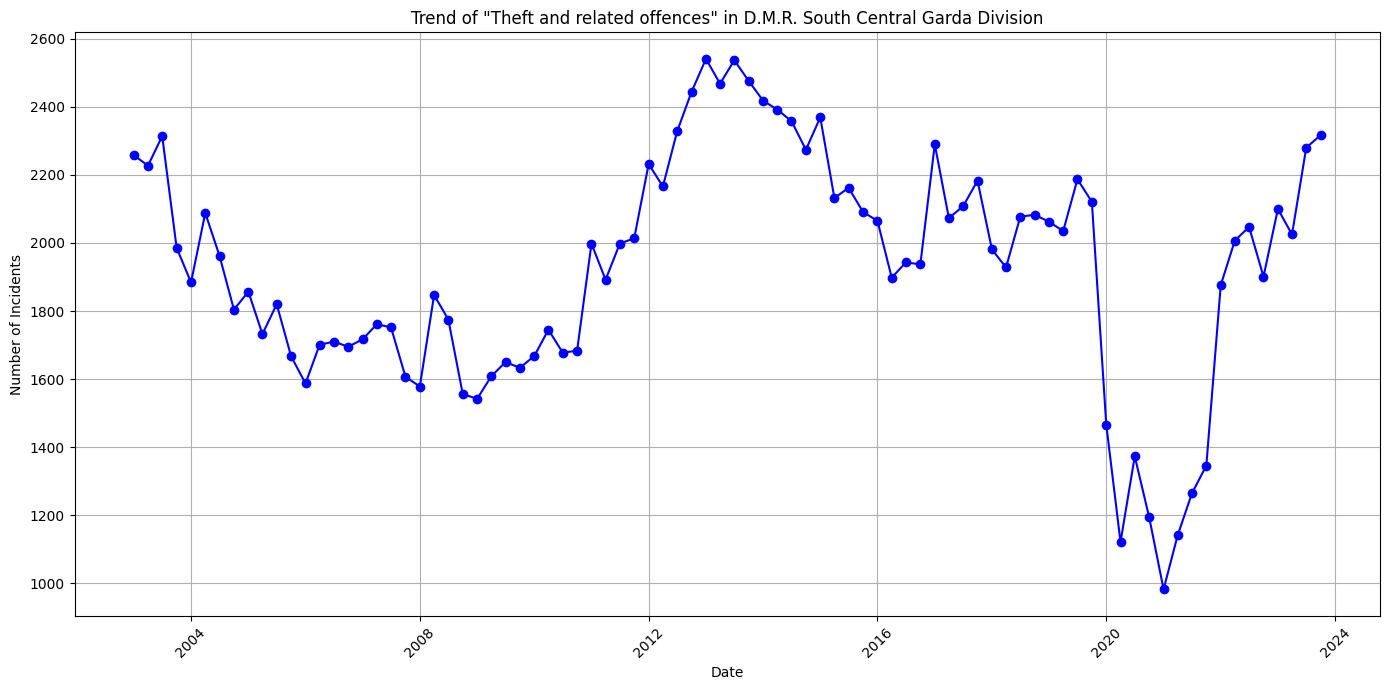

In [18]:
# Plotting the line graph
plt.figure(figsize=(14, 7))
plt.plot(theft_from_person_data['Date'], theft_from_person_data['Crime'], marker='o', linestyle='-', color='b')
plt.title('Trend of "Theft and related offences" in D.M.R. South Central Garda Division')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

In [19]:
theft_from_person_data.head()

Crime       Date
1599   2258 2003-01-01
3587   2227 2003-04-01
5575   2314 2003-07-01
7563   1986 2003-10-01
9551   1884 2004-01-01

In [20]:
theft_from_person_data.set_index('Date', inplace=True)

In [21]:
train = theft_from_person_data.loc['2003-01-01': '2017-10-01']
test = theft_from_person_data.loc['2018-01-01':'2019-10-01']

In [22]:
test

Crime
Date             
2018-01-01   1981
2018-04-01   1928
2018-07-01   2077
2018-10-01   2083
2019-01-01   2062
2019-04-01   2035
2019-07-01   2187
2019-10-01   2121

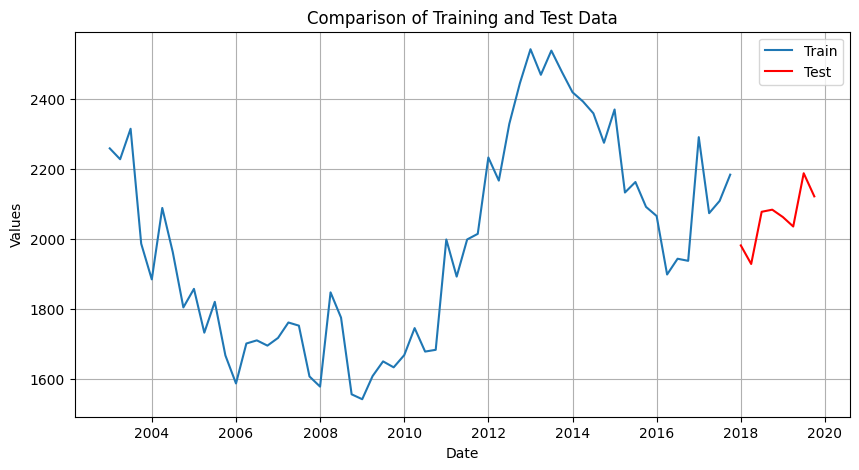

In [23]:
# Plotting
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(train.index, train['Crime'], label='Train')  # Replace 'your_column_name' with the actual column name
plt.plot(test.index, test['Crime'], label='Test', color='r')  # Replace 'your_column_name' with the actual column name
plt.title('Comparison of Training and Test Data')
plt.xlabel('Date')
plt.ylabel('Values')  # Adjust label as per your data context
plt.legend()
plt.grid(True)
plt.show()

In [24]:
theft_from_person_data.rename(columns={'Crime': 'y', 'Date': 'ds'}, inplace=True)

In [25]:
theft_from_person_data.reset_index(inplace=True)

In [26]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)
train.rename(columns={'Crime': 'y', 'Date': 'ds'}, inplace=True)
test.rename(columns={'Crime': 'y', 'Date': 'ds'}, inplace=True)

In [27]:
test

ds     y
0 2018-01-01  1981
1 2018-04-01  1928
2 2018-07-01  2077
3 2018-10-01  2083
4 2019-01-01  2062
5 2019-04-01  2035
6 2019-07-01  2187
7 2019-10-01  2121

In [28]:
m_prophet = Prophet(
    changepoint_prior_scale=0.5,   # Default is 0.05, increase for more flexibility
    seasonality_prior_scale=10.0,  # Default is 10, adjust as needed
    holidays_prior_scale=0.1,      # Default is 10, decrease for less flexible holidays
    seasonality_mode='multiplicative'  # Especially useful if seasonality magnitude grows over time
)
model_prophet = m_prophet.fit(train)

23:19:19 - cmdstanpy - INFO - Chain [1] start processing
23:19:20 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
future_prophet = m_prophet.make_future_dataframe(periods=7, freq = 'QS')


In [30]:
forecast_prophet = m_prophet.predict(future_prophet)
forecast_prophet[['ds', 'yhat']].tail(7)



ds         yhat
60 2018-01-01  2094.560939
61 2018-04-01  2043.546677
62 2018-07-01  2084.645552
63 2018-10-01  1996.790439
64 2019-01-01  2018.033097
65 2019-04-01  2024.451543
66 2019-07-01  2084.164608

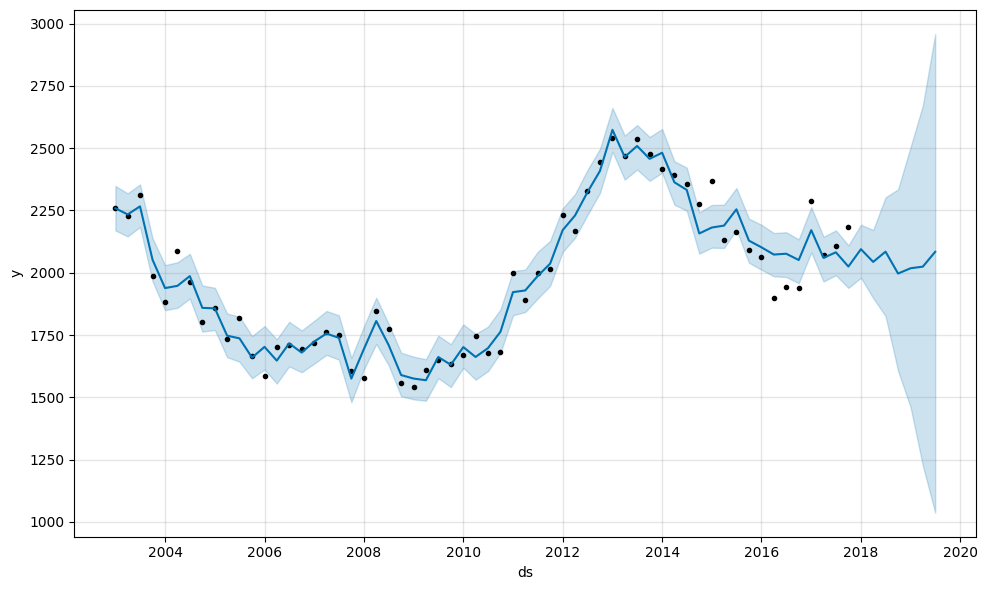

In [31]:
plot1 = m_prophet.plot(forecast_prophet)

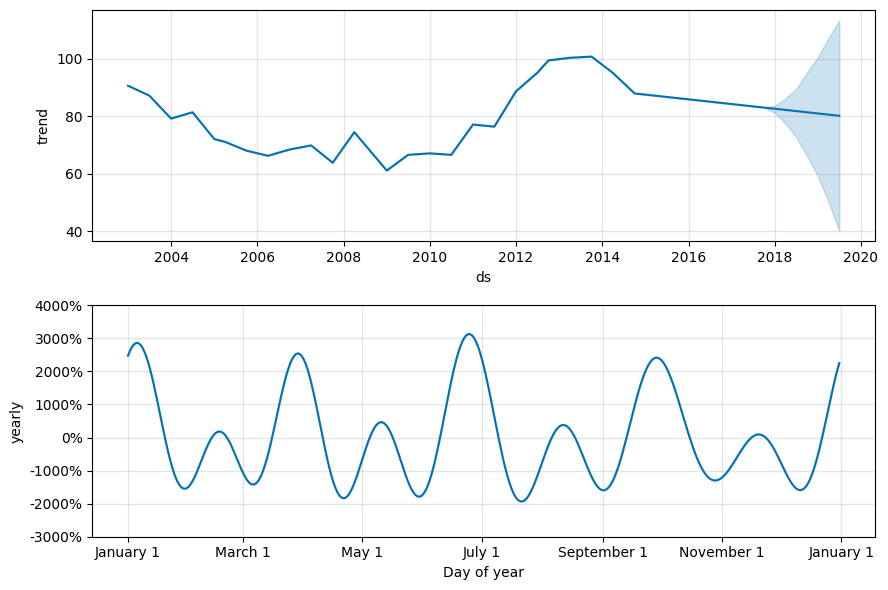

In [32]:
plot2 = m_prophet.plot_components(forecast_prophet)

In [33]:


np.sqrt(mean_squared_error(y_true=test['y'], 
                          y_pred=forecast_prophet['yhat'].tail(8)))


88.81333009622236

In [34]:
mean_absolute_error(y_true=test['y'],
                              y_pred=forecast_prophet['yhat'].tail(8))

65.87841797217038

In [36]:
# Assuming 'theft_from_person_data' is your actual data and 'forecast' is your prediction
# Filter 'forecast' to match the date range in 'theft_from_person_data'
forecast_filtered = forecast_prophet[forecast_prophet['ds'].isin(train['ds'])]

# Now, reassign y_pred to make sure it only includes matched predictions
y_pred = forecast_filtered['yhat'].values
y_true = train['y'].values

# Calculate R² score
r2 = r2_score(y_true, y_pred)
print(f"R² Score: {r2}")



R² Score: 0.9432922491315333


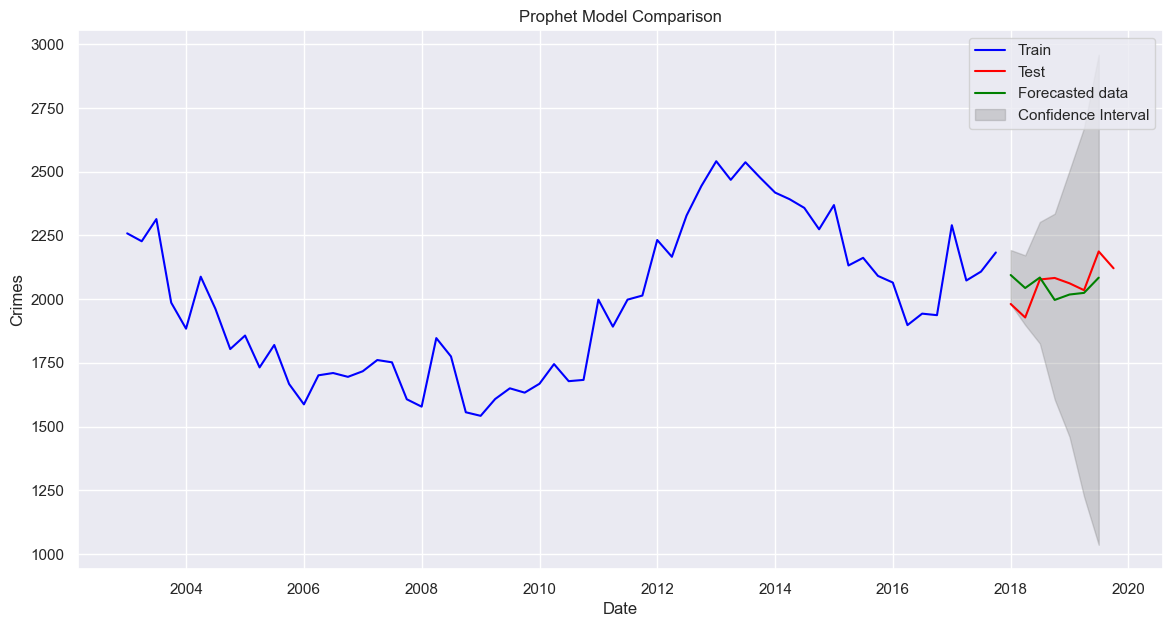

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train['ds'], train['y'], label='Train', color='blue')

# Plot test data
plt.plot(test['ds'], test['y'], label='Test', color='red')

# Plot forecast
forecast_period = forecast_prophet[(forecast_prophet['ds'] >= test['ds'].min()) & (forecast_prophet['ds'] <= test['ds'].max())]
plt.plot(forecast_period['ds'], forecast_period['yhat'], label='Forecasted data', color='green')

plt.fill_between(forecast_period['ds'], forecast_period['yhat_lower'], forecast_period['yhat_upper'], color='gray', alpha=0.3, label='Confidence Interval')


plt.title('Prophet Model Comparison')
plt.xlabel('Date')
plt.ylabel('Crimes')
plt.legend()
plt.grid(True)
plt.show()
